# 분석에 필요한 파생컬럼 생성 및 테이블 조인

In [118]:
import pandas as pd
import numpy as np

art = pd.read_csv("data/art_processed.csv")                 # 상품 메타데이터
cust = pd.read_csv("data/cust_processed.csv")               # 고객 메타데이터
total_revenue = pd.read_csv("data/total_revenue.csv")

# 고객등급분류. 내용자체는 total_revenue에 들어가있음
customer_revenue = pd.read_csv("data/customer_revenue.csv")

# art_processed 데이터

In [119]:
# ----------------------------------------------------
# 상품 메타데이터
# 상품군 / 색상 / 톤 / 카테고리별 매출 분석의 기반
# 상위 20%, 하위 20% 고객이 어떤 상품군을 소비할까?, 접근한 상품 특성이 무었일까?
# 거래데이터와 조인 해보기
# ----------------------------------------------------
art.info()

<class 'pandas.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   article_id         105542 non-null  int64
 1   product_code       105542 non-null  int64
 2   product_type_code  105542 non-null  int64
 3   product_type       105542 non-null  str  
 4   product_group      105542 non-null  str  
 5   garment_group      105542 non-null  str  
 6   index_group_code   105542 non-null  int64
 7   index_group        105542 non-null  str  
 8   index_name         105542 non-null  str  
 9   section_code       105542 non-null  int64
 10  section            105542 non-null  str  
 11  graphic            105542 non-null  str  
 12  color              105542 non-null  str  
 13  tone               105542 non-null  str  
 14  color_master_code  105542 non-null  int64
 15  color_master       105542 non-null  str  
 16  prod_name          105542 non-null  str  
dtypes:

In [120]:
art.shape

(105542, 17)

In [121]:
art.head()

,article_id,product_code,product_type_code,product_type,product_group,garment_group,index_group_code,index_group,index_name,section_code,section,graphic,color,tone,color_master_code,color_master,prod_name
0,108775015,108775,253,Vest top,Garment Upper body,Jersey Basic,1,Ladieswear,Ladieswear,16,Womens Everyday Basics,Solid,Black,Dark,5,Black,Strap top
1,108775044,108775,253,Vest top,Garment Upper body,Jersey Basic,1,Ladieswear,Ladieswear,16,Womens Everyday Basics,Solid,White,Light,9,White,Strap top
2,108775051,108775,253,Vest top,Garment Upper body,Jersey Basic,1,Ladieswear,Ladieswear,16,Womens Everyday Basics,Stripe,Off White,Dusty Light,9,White,Strap top (1)
3,110065001,110065,306,Bra,Underwear,"Under-, Nightwear",1,Ladieswear,Lingeries/Tights,61,Womens Lingerie,Solid,Black,Dark,5,Black,OP T-shirt (Idro)
4,110065002,110065,306,Bra,Underwear,"Under-, Nightwear",1,Ladieswear,Lingeries/Tights,61,Womens Lingerie,Solid,White,Light,9,White,OP T-shirt (Idro)


In [122]:
na_a = art.isna().sum().sort_values(ascending=False) 
na_a.head(3)

article_id           0
product_code         0
product_type_code    0
dtype: int64

크기: 105,542행 × 17열<br>
키값:키: article_id<br>
결측/중복: 존재 X<br>

- article_id              : 개별 상품을 식별하는 고유 ID
- product_code            : 동일한 디자인·모델을 묶는 상품 그룹 코드
- product_type_code       : 상품 유형을 나타내는 코드
- product_type            : 상품의 구체적인 유형 이름
- product_group           : 상품의 상위 그룹 (의류, 액세서리 등의 대분류)
- garment_group           : 의류 그룹 (상의, 하의, 아우터 등)
- index_group_code        : 타겟 고객군 분류 코드(여성, 남성, 아동 등)
- index_group             : 타겟 고객군 대분류 이름
- index_name              : index_group의 세부 라인/컬렉션 이름
- section_code            : 상품이 속한 매장/카테고리 섹션 코드
- section                 : 매장 또는 온라인 내 상품 진열 섹션 이름
- graphic                 : 상품 외형
- color                   : 상품의 개별 색상명
- tone                    : 색상의 명도·톤 분류(밝음/어두움 계열)
- color_master_code       : 색상 대분류를 나타내는 코드
- color_master            : 색상의 대표 그룹명(Black, Blue 등)
- prod_name               : 상품 이름 (삭제 예정)

절대로 안쓸거 같은 데이터
- prod_name

# total&customer_revenue 데이터

In [123]:
# ----------------------------------------------------
# 거래테이블
# 
# 필요에 따라 상품, 고객 테이블과 조인
# ----------------------------------------------------
total_revenue.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   t_dat          1048575 non-null  str    
 1   customer_id    1048575 non-null  str    
 2   article_id     1048575 non-null  int64  
 3   revenue        1048575 non-null  float64
 4   year           1048575 non-null  int64  
 5   month          1048575 non-null  int64  
 6   year_month     1048575 non-null  str    
 7   channel        1048575 non-null  str    
 8   total_revenue  1048575 non-null  float64
 9   revenue_group  1048575 non-null  str    
dtypes: float64(2), int64(3), str(5)
memory usage: 80.0 MB


In [124]:
total_revenue.shape

(1048575, 10)

In [125]:
# ----------------------------------------------------
# 고객등급 정의용
# 상위 20%, 하위 20% 그외로 구성
# ----------------------------------------------------
customer_revenue.info()

<class 'pandas.DataFrame'>
RangeIndex: 458235 entries, 0 to 458234
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    458235 non-null  str    
 1   total_revenue  458235 non-null  float64
 2   revenue_group  458235 non-null  str    
dtypes: float64(1), str(2)
memory usage: 10.5 MB


In [126]:
customer_revenue.shape

(458235, 3)

customer_revenue
- customer_id : 고객을 식별하는 고유 ID(다른 테이블과 조인 키로 사용)
- total_revenue : 해당 고객의 전체 구매금액 합계
- revenue_group : 해당 고객의 매출 등급(bottom_20 / middle / top_20)이다

total_revenue
- t_dat : 거래일(YYYY-MM-DD)로, 시계열 파생(연/월/요일)의 기준 컬럼이다
- customer_id : 거래를 만든 고객 ID로, 고객 단위 집계/등급 조인 키
- article_id : 거래된 상품 ID로, articles 테이블의 조인 키
- revenue : 거래 1건의 구매금액(원본 price를 revenue로 rename)
- year : t_dat에서 뽑은 연도 파생 컬럼
- month : t_dat에서 뽑은 월 파생 컬럼
- year_month : t_dat를 연-월 단위로 묶은 문자열 파생 컬럼
- channel : 판매 채널(online/offline)
- total_revenue : 해당 고객의 전체 구매금액 합계
- revenue_group : 해당 고객의 매출 등급(bottom_20 / middle / top_20)

# cust_processed 데이터

In [127]:
# ----------------------------------------------------
# 고객 속성 정리 테이블
# 구독여부, 연령대
# 거래데이터와 조인 해보기
# ----------------------------------------------------
cust.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype
---  ------                  --------------    -----
 0   customer_id             1048575 non-null  str  
 1   FN                      1048575 non-null  bool 
 2   Active                  1048575 non-null  bool 
 3   club_member_status      1048575 non-null  str  
 4   fashion_news_frequency  372184 non-null   str  
 5   age                     1048575 non-null  int64
 6   age_group               1048575 non-null  str  
dtypes: bool(2), int64(1), str(4)
memory usage: 42.0 MB


In [128]:
cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,False,False,ACTIVE,NaN,49,40s
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,False,False,ACTIVE,NaN,25,20s
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,False,False,ACTIVE,NaN,24,20s
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,False,False,ACTIVE,NaN,54,50s
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,True,True,ACTIVE,Regularly,52,50s


In [129]:
na_c = cust.isna().sum().sort_values(ascending=False) 
na_c.head(3)

fashion_news_frequency    676391
FN                             0
customer_id                    0
dtype: int64

크기: 1,048,575 rows × 7 cols<br>
키값: customer_id<br>
<br>

- customer_id : 고객을 식별하는 고유 ID
- Active : 고객 활성 상태를 나타내는 값 (최근에 H&M과 상호작용 이력이 있는 고객)
- FN : 패션 뉴스(Fashion News) 관련 여부를 나타내는 값
- club_member_status : H&M 멤버십 상태 정보(ACTIVE / PRE-CREATE / LEFT CLUB)
- fashion_news_frequency : 패션 뉴스레터 수신 빈도(None / Regular 등)
- age : 고객의 나이(이상치 제거·연령대 파생의 기준 변수)
- age_group : age로 만든 연령대 파생 컬럼

# 파생컬럼 생성 및 테이블 생성

In [130]:
# 시간을 표현하는 다른 변수들이 있어서 필요업삳고 판단해서 삭제
total_revenue = total_revenue.drop(columns=["t_dat"], errors="ignore")

In [131]:
# # ---------------------------------------------------------------------
# 분석용 통합 테이블 거래+고객+상품
# 볼수 있는 데이터
# ==  거래(매출, 채널, 날짜, 고객그룹) + 고객속성 + 상품속성
# 가입한 사람이 아닌 소비한 고객을 골라야 하기 때문에 inner 사용
# ---------------------------------------------------------------------

analysis_master = (
    total_revenue
    .merge(cust, on="customer_id", how="inner")
    .merge(art, on="article_id", how="inner")
)
analysis_master.shape

(812931, 31)

- 관측 단위: 거래 1건
- 상위/ 하위 20%라벨 모두 존재
- 고객 속성 + 상품 속성 모두 있음

In [132]:
analysis_master.head()

,customer_id,article_id,revenue,year,month,year_month,channel,total_revenue,revenue_group,FN,...,index_group,index_name,section_code,section,graphic,color,tone,color_master_code,color_master,prod_name
0,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2019,11,2019-11,online,0.227186,top_20,True,...,Divided,Divided,53,Divided Collection,Placement print,Dark Blue,Dark,2,Blue,ZEBRA CF TVP
1,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2019,5,2019-05,online,0.067746,middle,False,...,Ladieswear,Ladieswear,6,Womens Casual,Stripe,White,Light,9,White,BUBBLE WRAP TOP
2,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2019,5,2019-05,online,0.016932,bottom_20,True,...,Menswear,Menswear,21,Contemporary Casual,Chambray,Dark Blue,Dark,2,Blue,Teddy jogger.
3,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2019,8,2019-08,online,0.033881,middle,False,...,Ladieswear,Ladies Accessories,65,Womens Big accessories,Solid,Black,Dark,5,Black,Yuki shopper
4,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,2019,8,2019-08,offline,0.028627,middle,False,...,Menswear,Menswear,26,Men Underwear,All over pattern,White,Light,9,White,1pk Sportsock


In [133]:
import matplotlib.pyplot as plt

# Analysis Base (실제 분석용 테이블)

In [134]:
analysis_base = analysis_master[
    [
        # 키(필수: 고객 수 계산용)
        "customer_id",
        # 고객 등급
        "revenue_group",
        # 매출
        "revenue",
        # 채널
        "channel",
        # 고객 속성
        "age_group",
        "club_member_status",
        "FN",
        "Active",
        # 상품 속성
        "product_group",
        "garment_group",
        "color_master",
    ]
].copy()

## 서비스 현황 파악

# 반드시 있어야 할 것
전체 매출 규모
- 총 매출
- 고객 수
- 거래 수

채널별 매출 현황
- online vs offline 매출 비중
- 구매 횟수 비중

고객 등급별 매출 분포
- top / middle / bottom 매출 비중

### 총 매출/거래 수
- total_revenue : 전체 서비스에서 발생한 매출 규모
- transaction_cnt : 전체 거래 횟수
- customer_cnt : 구매 이력이 있는 실제 고객 수

In [135]:
total_revenue = analysis_base["revenue"].sum()
transaction_cnt = analysis_base["revenue"].count()
customer_cnt = analysis_base["customer_id"].nunique()

overall_summary = pd.Series(
    {
        "total_revenue": total_revenue,
        "transaction_cnt": transaction_cnt,
        "customer_cnt": customer_cnt,
    }
)

overall_summary

total_revenue       22578.648319
transaction_cnt    812931.000000
customer_cnt       353560.000000
dtype: float64

전체 거래 데이터를 기준으로 분석한 결과, <br>
총 매출은 22,578.65 SEK,<br>
총 거래 건수는 812,931건,<br>
구매 이력이 있는 고객 수는 353,560명으로 나타났다.<br>

> 이번 분석에선 절대적인 매출 규모를 파악하기 어렵기 때문에 고객 등급 및 채널·상품군별 상대적인 매출 구조의 경향성에 초점을 맞추어 해석을 진행하였습니다.

### 채널별 매출 현황

In [136]:
# 채널별 매출과 거래 수
channel_overview = (
    analysis_base
    .groupby("channel")
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count")
    )
)

channel_overview

# 총 거래 건수: 812,931
# offline은 247412건, 매출은 : 5637.23sek
# online은 565519건, 매출은: 16941.41sek
# 거래건수, 매출 모두 압도적으로 온라인이 많음


,revenue_sum,transaction_cnt
channel,,
offline,5637.231940,247412
online,16941.416379,565519


In [137]:
# 채널 비중 계산
channel_ratio = channel_overview.copy()

channel_ratio["revenue_ratio"] = (
    channel_ratio["revenue_sum"]
    / channel_ratio["revenue_sum"].sum()
)

channel_ratio["transaction_ratio"] = (
    channel_ratio["transaction_cnt"]
    / channel_ratio["transaction_cnt"].sum()
)

channel_ratio


,revenue_sum,transaction_cnt,revenue_ratio,transaction_ratio
channel,,,,
offline,5637.231940,247412,0.249671,0.304346
online,16941.416379,565519,0.750329,0.695654


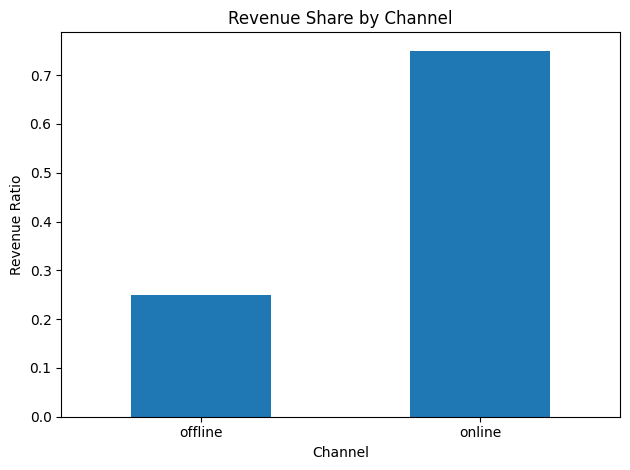

In [138]:
# 시각화

channel_ratio["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Channel")
plt.xlabel("Channel")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

온라인 채널
- 매출 비중: 약 75.0%
- 거래 비중: 약 69.6%

오프라인 채널
- 매출 비중: 약 25.0%
- 거래 비중: 약 30.4%

> 이를 시각화한 결과, 온라인 채널이 전체 매출에서 차지하는 비중이 오프라인 채널보다 크게 나타났습니다.

온라인 채널은 거래 비중 대비 매출 비중이 더 높게 나타났으며, 이는 온라인 채널에서의 평균 거래 금액이 오프라인 채널보다 더 높은 경향을 보이는것을 의미합니다. <br>
반면에 오프라인 채널은 거래 비중 대비 매출 기여도가 상대적으로 낮은편으로, 예측컨데 비교적 저가 상품중심의 구매가 이루어졌을 가능성이 존재합니다.

> 매출구조는 제대로 파악할수 없기 때문에 상대적인 경향성 파악에 초점을 둔 해석입니다. <br> 현실과의 어느정도 차이를 보일순 있으나, 경향성을 가짐에는 변함없습니다.

### 상품군별 매출 현황

In [139]:
# 의류 그룹 (상의, 하의, 아우터 등)
garment_overview = (
    analysis_base
    .groupby("garment_group", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count")
    )
    .sort_values("revenue_sum", ascending=False)
)

garment_overview.head(10)


,garment_group,revenue_sum,transaction_cnt
6,Jersey Fancy,3023.979908,130209
16,Trousers,2612.067862,75035
3,Dresses Ladies,2109.021387,57728
7,Knitwear,1972.790201,62048
1,Blouses,1815.358221,65117
15,Swimwear,1531.465622,68170
18,"Under-, Nightwear",1506.623486,72169
17,Trousers Denim,1298.521879,32849
8,Outdoor,1291.890644,18544
5,Jersey Basic,1226.540421,80298


In [140]:
garment_overview["revenue_ratio"] = (
    garment_overview["revenue_sum"]
    / garment_overview["revenue_sum"].sum()
)

garment_overview["transaction_ratio"] = (
    garment_overview["transaction_cnt"]
    / garment_overview["transaction_cnt"].sum()
)

garment_overview.head(10)

# revenue_sum: 총매출
# transaction_cnt: 구매횟수
# revenue_ratio: 전체 매출 중에서 해당 상품군이 차지하는 매출 비중
# transaction_ratio: 전체 거래 중에서 해당 상품군이 차지하는 구매 횟수(거래) 비중

,garment_group,revenue_sum,transaction_cnt,revenue_ratio,transaction_ratio
6,Jersey Fancy,3023.979908,130209,0.133931,0.160172
16,Trousers,2612.067862,75035,0.115688,0.092302
3,Dresses Ladies,2109.021387,57728,0.093408,0.071012
7,Knitwear,1972.790201,62048,0.087374,0.076326
1,Blouses,1815.358221,65117,0.080402,0.080102
15,Swimwear,1531.465622,68170,0.067828,0.083857
18,"Under-, Nightwear",1506.623486,72169,0.066728,0.088776
17,Trousers Denim,1298.521879,32849,0.057511,0.040408
8,Outdoor,1291.890644,18544,0.057217,0.022811
5,Jersey Basic,1226.540421,80298,0.054323,0.098776


상위 상품군만 추려보면
- Jersey Fancy: 매출 비중 약 13.4%
- Trousers: 매출 비중 약 11.6%
- Dresses Ladies: 매출 비중 약 9.3%
- Knitwear: 매출 비중 약 8.7%
- Blouses: 매출 비중 약 8.0%

서비스의 주요 매출을 견인하는 핵심 상품군이라 볼수 있다.

- Trousers, Dresses Ladies, Outdoor 상품군은 거래 비중보다 매출 비중이 높아 상대적으로 평균 구매 금액이 높은 상품군으로 해석할 수 있다.

- Jersey Basic, Under-, Nightwear, Swimwear 상품군은 거래 비중 대비 매출 비중이 낮아 비교적 단가가 낮고 자주 구매되는 상품군의 특성을 보인다.

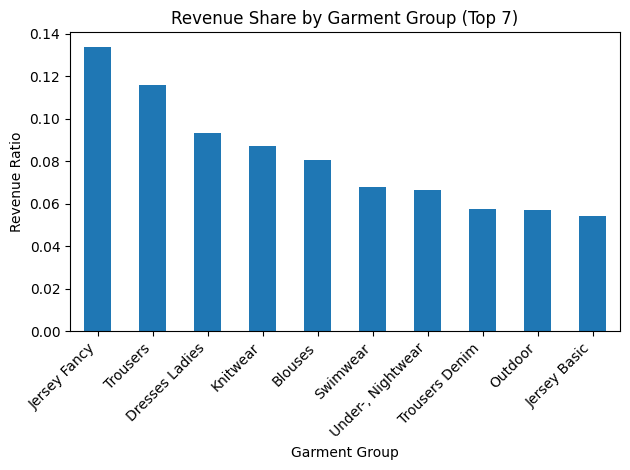

In [141]:
# 가장 판매량이 많은 7개 항목만 출력
top_garments = garment_overview.head(10)

import matplotlib.pyplot as plt

top_garments.set_index("garment_group")["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Garment Group (Top 7)")
plt.xlabel("Garment Group")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


상품군별 매출 비중을 막대그래프로 시각화한 결과, 매출이 특정 상품군에 고르게 분포되어 있기보다는 상위 상품군에 집중되는 구조임을 확인할 수 있다.

- 매출은 Jersey 계열, 바지, 원피스 등 주요 의류 상품군을 중심으로 형성되어 있다.
- 일부 상품군은 거래 대비 매출 기여도가 높아 상대적으로 고가 상품군의 특성을 보인다.
- 반대로 기본 의류 상품군은 거래 빈도는 높으나 매출 기여도는 상대적으로 낮다.


> 상품군별 매출 분포를 기준으로 한 결과로, 공급량, 가격 정책, 이밴트(프로모션?) 등 외부 요인은 반영되지 않았습니다.

### 고객특성별 매출 현황

In [142]:
# 멤버십 상태별 매출
member_overview = (
    analysis_base
    .groupby("club_member_status", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count"),
        customer_cnt=("customer_id", "nunique")
    )
)

member_overview["revenue_ratio"] = (
    member_overview["revenue_sum"]
    / member_overview["revenue_sum"].sum()
)

member_overview


,club_member_status,revenue_sum,transaction_cnt,customer_cnt,revenue_ratio
0,ACTIVE,22067.120304,796063,342000,0.977345
1,LEFT CLUB,7.770949,260,112,0.000344
2,PRE-CREATE,503.757067,16608,11448,0.022311


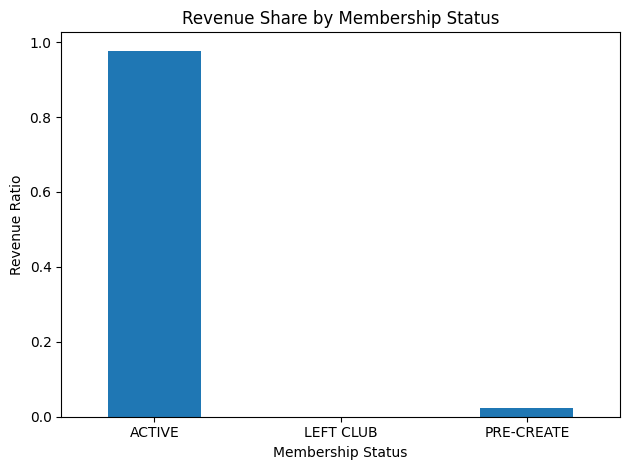

In [143]:
import matplotlib.pyplot as plt

member_overview.set_index("club_member_status")["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Membership Status")
plt.xlabel("Membership Status")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


멤버십 상태별 매출을 분석한 결과, ACTIVE 멤버십 고객이 전체 매출의 약 97.7%를 차지하는 것으로 나타났다.<br>
반면, PRE-CREATE 고객은 약 2.2%, LEFT CLUB 고객은 매우 미미한 수준의 매출 비중을 보였다.<br>
즉, 이는 현재 활성화된 멤버십 고객이 서비스 매출의 핵심 고객군임을 보여준다.

> 다만, 멤버십 상태가 매출의 직접적인 원인임을 의미하지 않으며 구매 활동이 활발한 고객이 멤버십을 유지하고 있을 가능성이 있기 때문에 큰 의미가 있다 볼순 없다

In [144]:
# 뉴스 구독(FN) 여부별 매출
fn_overview = (
    analysis_base
    .groupby("FN", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count"),
        customer_cnt=("customer_id", "nunique")
    )
)

fn_overview["revenue_ratio"] = (
    fn_overview["revenue_sum"]
    / fn_overview["revenue_sum"].sum()
)

fn_overview

,FN,revenue_sum,transaction_cnt,customer_cnt,revenue_ratio
0,False,12897.746978,461066,209461,0.571236
1,True,9680.901341,351865,144099,0.428764


뉴스레터 수신 여부에 따른 매출을 분석한 결과, 뉴스를 수신하지 않는 고객이 약 57.1%, 뉴스를 수신하는 고객이 약 42.9%의 매출 비중을 차지하는것을 확인하였다. <br>

> 뉴스레터 수신 여부에 따라 매출 규모 차이가 관찰되었으나, 이는 고객 수 차이에 따른 결과일 가능성이 있다.

In [145]:
# Active 여부별 매출
active_overview = (
    analysis_base
    .groupby("Active", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count"),
        customer_cnt=("customer_id", "nunique")
    )
)

active_overview["revenue_ratio"] = (
    active_overview["revenue_sum"]
    / active_overview["revenue_sum"].sum()
)

active_overview


,Active,revenue_sum,transaction_cnt,customer_cnt,revenue_ratio
0,False,13021.715605,465767,211728,0.576727
1,True,9556.932714,347164,141832,0.423273


고객의 활동 상태(Active 여부)에 따른 매출을 분석한 결과, 비활성(False) 고객이 약 57.7%, 활성(True) 고객이 약 42.3%의 매출 비중을 차지했다. Active 고객은 고객 수 대비 상대적으로 높은 매출 기여도를 보이는 경향이 있다.

> Active 변수는 고객의 최근 활동 여부를 나타내는 상태 정보로, 매출의 원인보다는 현재 고객 특성을 설명하는 지표로 해석하였다.

### 상위 하위 20% 비중/고객 등급별 매출 분포

In [146]:
revenue_by_group = (
    analysis_base
    .groupby("revenue_group")
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count")
    )
)

revenue_by_group

,revenue_sum,transaction_cnt
revenue_group,,
bottom_20,885.749264,73302
middle,9439.982903,369015
top_20,12252.916153,370614


In [147]:
# 비중
revenue_by_group["revenue_ratio"] = (
    revenue_by_group["revenue_sum"]
    / revenue_by_group["revenue_sum"].sum()
)

revenue_by_group

,revenue_sum,transaction_cnt,revenue_ratio
revenue_group,,,
bottom_20,885.749264,73302,0.039230
middle,9439.982903,369015,0.418093
top_20,12252.916153,370614,0.542677


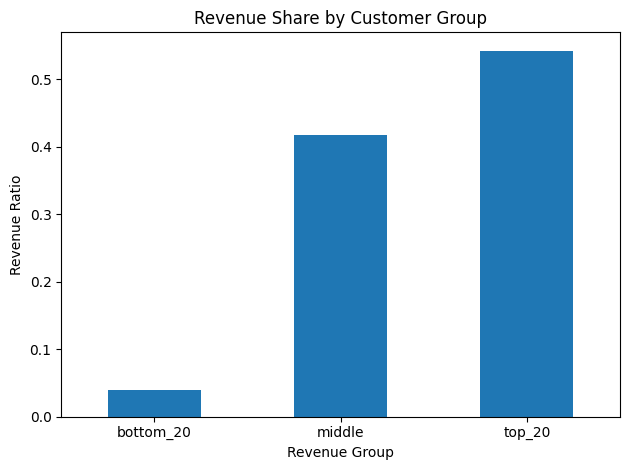

In [148]:
import matplotlib.pyplot as plt

revenue_by_group["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Customer Group")
plt.xlabel("Revenue Group")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


상위 20% 고객들은 거래를 더 자주 하기 때문에 고객 수는 20%여도, 거래 행에서는 45% 정도<br>
반면 하위 20% 고객은 거래 횟수와 매출 기여도 모두 낮은 수준을 보였다.

> 거래 기준 분포에서 상위 고객군(top_20)이 전체 거래의 약 46%를 차지하였다. 이는 상위 고객군이 평균적으로 더 빈번하게 구매하는 경향이 있음을 시사한다.

> 매출 금액은 데이터 전처리 과정에서 스케일이 변형되었을 가능성이 있어 절대값 해석보다는 그룹 간 상대 비교에 초점을 맞추었다.

## 채널 분석

In [149]:
channel_summary = (
    analysis_base
    .groupby(["revenue_group", "channel"], as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        purchase_cnt=("revenue", "count")
    )
)


channel_summary

,revenue_group,channel,revenue_sum,purchase_cnt
0,bottom_20,offline,416.434472,36776
1,bottom_20,online,469.314792,36526
2,middle,offline,3232.680997,138108
3,middle,online,6207.301906,230907
4,top_20,offline,1988.116472,72528
5,top_20,online,10264.799681,298086


상위 20% 고객은 온라인 채널에서의 매출 비중이 상대적으로 높게 나타났으며, 하위 20% 고객은 채널 간 매출 차이가 크지 않다.

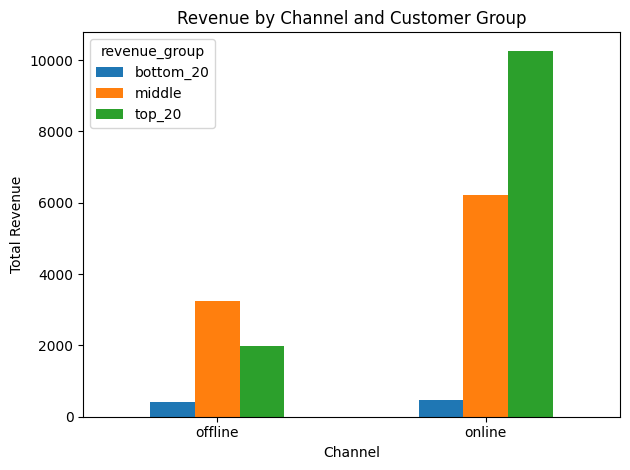

In [150]:
# 매출 기준 채널 비교 (가장 중요)

pivot_channel_rev = channel_summary.pivot(
    index="channel",
    columns="revenue_group",
    values="revenue_sum"
)

pivot_channel_rev.plot(kind="bar")
plt.title("Revenue by Channel and Customer Group")
plt.xlabel("Channel")
plt.ylabel("Total Revenue")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


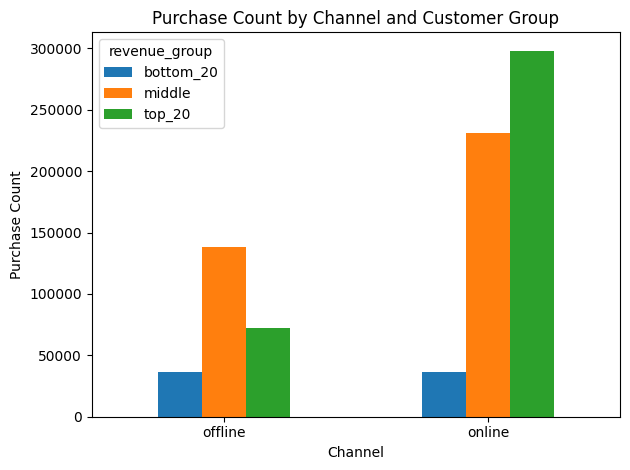

In [151]:
# 구매 횟수 기준 채널 비교

pivot_channel_cnt = channel_summary.pivot(
    index="channel",
    columns="revenue_group",
    values="purchase_cnt"
)

pivot_channel_cnt.plot(kind="bar")
plt.title("Purchase Count by Channel and Customer Group")
plt.xlabel("Channel")
plt.ylabel("Purchase Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


고객 매출 등급과 채널을 함께 분석한 결과, 상위 20% 고객은 온라인 채널에서의 매출과 구매 횟수가 모두 높게 나타났다. <br>반면 하위 20% 고객은 채널별 매출 및 구매 활동이 전반적으로 낮은 수준을 보였다.

> 이는 상위 고객이 온라인 채널을 주요 구매 채널로 활용하고 있을 가능성을 시사하며, 채널 접근성과 구매 편의성이 매출 규모 차이에 영향을 미쳤을 수 있다.

> 다만 본 분석은 관찰된 패턴을 기반으로 분석한것으로, 채널 이용이 매출 증가의 직접적인 원인임을 의미하지는 않는다.

## 상품군 분석

In [152]:
# 상품군 분석
garment_summary = (
    analysis_base
    .groupby(["revenue_group", "garment_group"], as_index=False)
    .agg(
        revenue_sum=("revenue", "sum")
    )
)

In [153]:
top_garments = (
    garment_summary
    .groupby("garment_group")["revenue_sum"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

garment_top = garment_summary[
    garment_summary["garment_group"].isin(top_garments)
]

garment_top

,revenue_group,garment_group,revenue_sum
1,bottom_20,Blouses,45.584627
3,bottom_20,Dresses Ladies,23.297796
5,bottom_20,Jersey Basic,157.314643
6,bottom_20,Jersey Fancy,181.299184
7,bottom_20,Knitwear,45.446525
8,bottom_20,Outdoor,1.388593
15,bottom_20,Swimwear,88.844592
16,bottom_20,Trousers,25.400407
17,bottom_20,Trousers Denim,21.554457
18,bottom_20,"Under-, Nightwear",110.654406


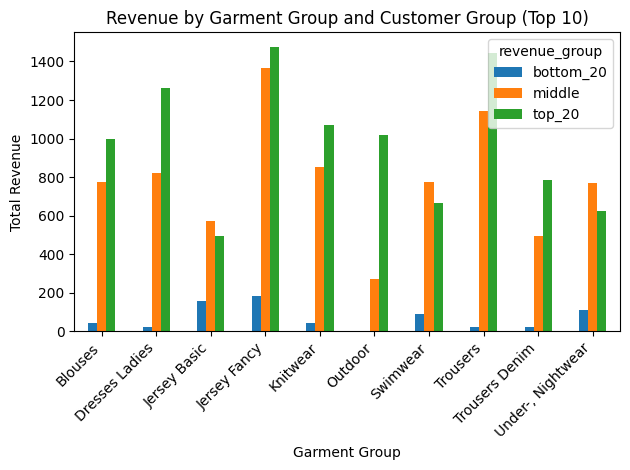

In [154]:
# 상품군 × 고객등급 매출 비교
pivot_garment = garment_top.pivot(
    index="garment_group",
    columns="revenue_group",
    values="revenue_sum"
)


pivot_garment.plot(kind="bar")
plt.title("Revenue by Garment Group and Customer Group (Top 10)")
plt.xlabel("Garment Group")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


상위 20% 고객과 하위 20% 고객 간 상품군별 매출 구조에는 뚜렷한 차이가 관찰되었다.

상위 10개 주요 의류 상품군 전반에서 고르게 높은 매출을 기록했다.<br>
특히 Jersey Fancy, Trousers, Dresses Ladies, Outdoor 등에서 매출 기여도가 높게 나타났다.<br>
이는 상위 고객이 특정 상품군에 국한되지 않고 다양한 의류 상품군을 폭넓게 구매하는 경향을 보임을 의미한다.

하위 20% 고객은 Jersey Basic, Under-, Nightwear 등 기본 의류 상품군에 매출이 집중되어있다.<br>
외출용·선택적 상품군(원피스, 바지, 아우터 등)에서는 매출이 매우 낮은 수준에 머물러있다.<br>
전반적으로 구매 범위가 제한적인 소비 패턴을 보인다.

상위 20% 고객은 특정 의류 상품군에 매출이 집중되는 경향을 보이는 반면, 하위 20% 고객은 기본 상품군 위주의 구매 패턴을 보인다.

중간 고객은 상위·하위 고객군 사이에서
- 대부분의 상품군에서 매출 규모가 중간 수준을 유지
- 상·하위 고객의 소비 패턴을 연결하는 완충 역할을 수행

이는 중간 고객이 상위 고객으로 전환될 가능성이 있는 핵심 전환 대상임을 시사한다.

In [155]:
analysis_base["product_group"].value_counts()

product_group
Garment Upper body       322201
Garment Lower body       180247
Garment Full body         91266
Swimwear                  69631
Underwear                 62464
Accessories               40536
Shoes                     19926
Socks & Tights            16398
Nightwear                  8783
Unknown                    1157
Bags                        172
Items                        85
Furniture                    26
Cosmetic                     24
Underwear/nightwear          11
Garment and Shoe care         4
Name: count, dtype: int64

In [156]:
analysis_master[
    analysis_master["product_group"].str.contains("access", case=False, na=False)
]["product_type"].value_counts()


product_type
Bag                  5846
Belt                 4948
Earring              4562
Scarf                3959
Sunglasses           3543
Necklace             3292
Hair/alice band      2363
Other accessories    2116
Hat/beanie           2057
Hair ties            1208
Hair clip            1006
Hair string           936
Ring                  873
Gloves                781
Cap/peaked            733
Hat/brim              690
Bracelet              253
Earrings              226
Watch                 173
Beanie                160
Dog Wear              153
Tie                   149
Wallet                130
Hairband               59
Waterbottle            57
Braces                 53
Umbrella               36
Straw hat              33
Soft Toys              30
Bucket hat             27
Cap                    24
Felt hat               22
Alice band             18
Headband               10
Baby Bib                6
Giftbox                 4
Name: count, dtype: int64

In [157]:
acc_month = (
    analysis_master[
        analysis_master["product_group"].str.contains("access", case=False, na=False)
    ]
    .groupby("year_month", as_index=False)
    .agg(revenue_sum=("revenue", "sum"))
)

acc_month

,year_month,revenue_sum
0,2019-01,51.034678
1,2019-02,48.518729
2,2019-03,48.172932
3,2019-04,51.016542
4,2019-05,53.805203
5,2019-06,50.628983
6,2019-07,52.561153
7,2019-08,44.804169
8,2019-09,53.662763
9,2019-10,55.052559


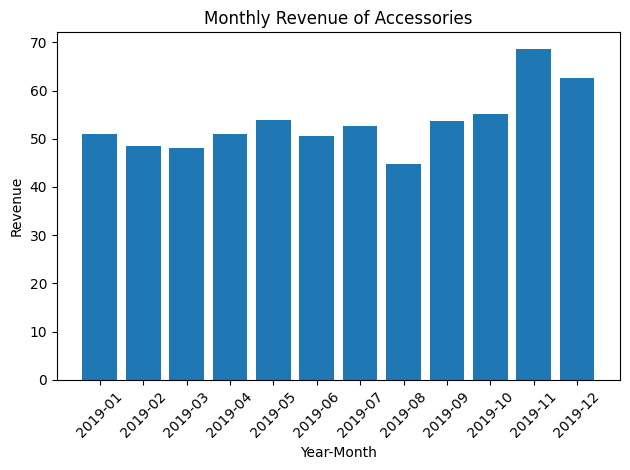

In [158]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(acc_month["year_month"], acc_month["revenue_sum"])
plt.title("Monthly Revenue of Accessories")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



11월, 12월에 어느정도 매출이 증가하는 경향을 보이긴 하나 큰 차이를 보이지 않았기 때문에, 특정 제품군 (반지 혹은 목걸이)을 한정적으로 분석하는게 좋음